In [1]:
import pandas as pd
import requests
import folium
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, mapping
from shapely import GeometryCollection, MultiPolygon
import json

In [2]:
PICKLE_PATH = "../data/pickled-sheepLamb.pickle"
FSIS_DATA = "../data/fsis-processors-with-location.csv"

In [3]:
# constants for coordinate projections
ALBERS_EQUAL_AREA = "EPSG:9822"
WGS84 = "EPSG:4326"

#### Load Chickens DF

In [5]:
df_small_sheepLamb = pd.read_pickle(PICKLE_PATH)

In [7]:
df_small_sheepLamb = gpd.GeoDataFrame(df_small_sheepLamb).set_geometry("Isochrone")
df_small_sheepLamb.head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
405,405,M13149 + P13149 + V13149,3743,Independent,Krehbiels Specialty Meats Inc,KS,Small,"Beef,Pork,Chicken,Turkey,Sheep/Lamb",3.0,3.0,"1636 Mohawk Rd., McPherson, KS 67460",38.409122,-97.624004,"POLYGON ((-97.66900 39.23940, -97.67054 39.235..."
408,408,M2800 + P2800,5179,Independent,Superior Farms,CA,Small,Sheep/Lamb,4.0,4.0,"7390 Rio Dixon Rd, Dixon, CA 95620",38.420077,-121.822343,"POLYGON ((-121.67534 39.19724, -121.67834 39.1..."
409,409,M47194,6165200,Independent,Colorado Lamb Processors,CO,Small,Sheep/Lamb,1.0,4.0,"1625 Agripark Road, Brush, CO 80723",40.282441,-103.617686,"POLYGON ((-103.66569 41.05366, -103.66688 41.0..."
410,410,M5883 + P5883,4898,Independent,Mountain Meadows Lamb Corporation,CO,Small,Sheep/Lamb,4.0,4.0,"4900 Clarkson Street, Denver, CO 80216",39.785791,-104.976580,"POLYGON ((-105.00058 40.64406, -105.00250 40.6..."
411,411,M10252,7198,Independent,Berry & Sons Rababeh Isl Slau,MI,Small,Sheep/Lamb,3.0,3.0,"2496 Orleans St., Detroit, MI 48207",42.347092,-83.036872,"POLYGON ((-83.07287 43.10869, -83.07506 43.096..."


In [8]:
# set CRS (coordinate reference system) for the dataframe
df_small_sheepLamb.set_crs(WGS84,inplace=True).head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone
405,405,M13149 + P13149 + V13149,3743,Independent,Krehbiels Specialty Meats Inc,KS,Small,"Beef,Pork,Chicken,Turkey,Sheep/Lamb",3.0,3.0,"1636 Mohawk Rd., McPherson, KS 67460",38.409122,-97.624004,"POLYGON ((-97.66900 39.23940, -97.67054 39.235..."
408,408,M2800 + P2800,5179,Independent,Superior Farms,CA,Small,Sheep/Lamb,4.0,4.0,"7390 Rio Dixon Rd, Dixon, CA 95620",38.420077,-121.822343,"POLYGON ((-121.67534 39.19724, -121.67834 39.1..."
409,409,M47194,6165200,Independent,Colorado Lamb Processors,CO,Small,Sheep/Lamb,1.0,4.0,"1625 Agripark Road, Brush, CO 80723",40.282441,-103.617686,"POLYGON ((-103.66569 41.05366, -103.66688 41.0..."
410,410,M5883 + P5883,4898,Independent,Mountain Meadows Lamb Corporation,CO,Small,Sheep/Lamb,4.0,4.0,"4900 Clarkson Street, Denver, CO 80216",39.785791,-104.976580,"POLYGON ((-105.00058 40.64406, -105.00250 40.6..."
411,411,M10252,7198,Independent,Berry & Sons Rababeh Isl Slau,MI,Small,Sheep/Lamb,3.0,3.0,"2496 Orleans St., Detroit, MI 48207",42.347092,-83.036872,"POLYGON ((-83.07287 43.10869, -83.07506 43.096..."


In [10]:
# simplify the isochrones for improved processing time
df_small_sheepLamb['Isochrone Cleaned'] = df_small_sheepLamb['Isochrone'].simplify(.05)

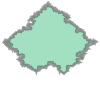

In [12]:
df_small_sheepLamb.iloc[0]['Isochrone']

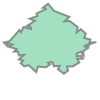

In [11]:
# shows the difference in resolution between the simplified and unsimplified isochrones
df_small_sheepLamb.iloc[0]['Isochrone Cleaned']

In [13]:
# list the states that contain poultry plants
df_small_sheepLamb.State.unique()

array(['KS', 'CA', 'CO', 'MI', 'TX', 'WV', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'KY', 'MA', 'MD', 'ME', 'MN', 'MO', 'MS', 'NC',
       'NE', 'NH', 'NJ', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'TN',
       'UT', 'VA', 'WI'], dtype=object)

In [14]:
# reassign the dataframe to df_map for processing later in the notebook
df_map = df_small_sheepLamb

### Create Map

In [15]:
# center of the USA: 37.0902° N, 95.7129° W
USA_LAT = 37.0902
USA_LNG = -95.7129

In [17]:
# folium requires these "color mapping functions" to add colors to the map
empty_color = lambda x: {
    "fillColor": "00" # empty
}

one_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

two_plant_color = lambda x: {
    "fillColor": "#ED7117" # carrot
}

three_plant_color = lambda x: {
    "fillColor": "#9F2B68" # amaranth
}

four_plant_color = lambda x: {
    "fillColor": "#90ee90" # light green
}

#### Add Plants to Map Layer and Extract Isochrones for Geospatial Processing

In [19]:
# add markers and isochrones to map
isochrones = []
# driving_distance_layer = folium.map.FeatureGroup(name="60 Mile Driving Distance")
plants_layer = folium.map.FeatureGroup(name="Small Sheep/Lamb Plants")

for index, row in df_map.iterrows():
    lat = str(row['latitude'])
    lng = str(row['longitude'])

    # set up plant tooltip
    name = row['Establishment Name']
    corp = row['Parent Corporation']
    address = row['Full Address']

    # add plant marker to map
    tooltip = folium.map.Tooltip(f"{name}<br>{address}<br>Parent Corporation: {corp}")
    folium.Marker(location=[lat, lng],tooltip=tooltip).add_to(plants_layer)

    isochrone = row['Isochrone Cleaned']
    isochrones.append(isochrone)
    
    # Can add the isochrones to the map, too, but this gets pretty cluttered with the other geospatial data
    # add driving radius isochrone to map layer
    # geojson = folium.GeoJson(row['Isochrone Cleaned'], style_function=empty_color)
    # geojson.add_to(driving_distance_layer)

In [20]:
len(isochrones)

99

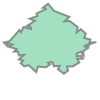

In [21]:
# example isochrone
isochrones[0]

#### Calculate Single-Plant Capture

In [22]:
# create single-plant capture area by removing one plant at a time and saving the area that is unique to that plant
single_plants_shapely = []
for index, poly in enumerate(isochrones):
    others = shapely.unary_union(isochrones[:index] + isochrones[index+1:])
    single_plant = shapely.difference(poly, others)
    single_plants_shapely.append(single_plant)

In [23]:
# create folium layer for single plant capture
single_plant_layer = folium.map.FeatureGroup(name="Access to 1 Plant")
single_plants_combined = shapely.unary_union(single_plants_shapely)
folium.GeoJson(single_plants_combined).add_to(single_plant_layer)

In [24]:
# calculate competitive area for filtering in the next stage
everything = shapely.unary_union(isochrones)
single_plant_combined = shapely.unary_union(single_plants_shapely)
competition_single_plant = shapely.difference(everything, single_plant_combined)

#### Calculate Two Plant Capture

In [25]:
# exclude any plants that are fully in single plant capture area
isochrones_shapely_two_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_single_plant):
        isochrones_shapely_two_plants.append(isochrone)

c:\Users\chacon1\AppData\Local\Programs\Python\Python39\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [26]:
len(isochrones_shapely_two_plants)

76

In [27]:
# logic here is similar to single plant capture with just a bit more complexity since we are now looking at two plant capture so we need to do a nested loop
two_plants_shapely = []
for i in range(len(isochrones_shapely_two_plants)):
    for j in range(i+1, len(isochrones_shapely_two_plants)):
        plant_1 = isochrones_shapely_two_plants[i]
        plant_2 = isochrones_shapely_two_plants[j]

        # check if there's an intersection between the areas
        if not plant_1.intersection(plant_2):
            continue
        else:
            two_plant_area = shapely.unary_union([plant_1,plant_2])

        # exclude first plant
        other_plants = isochrones_shapely_two_plants[:i]
        # exclude second plant
        other_plants += isochrones_shapely_two_plants[i+1:j]
        other_plants += isochrones_shapely_two_plants[j+1:]

        # find the area where there's only two plants
        others_combined = shapely.unary_union(other_plants)
        captured_area = shapely.difference(two_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
        # remove the area that is captured by only one of the plants
        captured_area = shapely.difference(captured_area, single_plant_combined)
        if captured_area:
            two_plants_shapely.append(captured_area)


In [28]:
len(two_plants_shapely)

108

In [29]:
two_plant_layer = folium.map.FeatureGroup(name="Access to 2 Plants")
two_plants_combined = shapely.unary_union(two_plants_shapely)
folium.GeoJson(two_plants_combined,style_function=two_plant_color).add_to(two_plant_layer)

In [30]:
# calculate competitive area for filtering in the next stage
competition_two_plant = shapely.difference(competition_single_plant, two_plants_combined)

#### Calculate Three Plant Competition Area

In [31]:
# exclude any plants that don't intersect with the competition area
isochrones_shapely_three_plants = []
for isochrone in isochrones:
    if isochrone.intersection(competition_two_plant):
        isochrones_shapely_three_plants.append(isochrone)

In [32]:
len(isochrones_shapely_three_plants)

51

In [33]:
# same idea as previous steps, now we just need to do this for three plants
three_plants_shapely = []
for i in range(len(isochrones_shapely_three_plants)):
    for j in range(i+1, len(isochrones_shapely_three_plants)):
        for k in range(j+1, len(isochrones_shapely_three_plants)):
            plant_1 = isochrones_shapely_three_plants[i]
            plant_2 = isochrones_shapely_three_plants[j]
            plant_3 = isochrones_shapely_three_plants[k]

            # check if there's an intersection between the areas
            if not plant_1.intersection(plant_2).intersection(plant_3):
                continue
            else:
                three_plant_area = shapely.unary_union([plant_1,plant_2,plant_3])

            # exclude first plant
            other_plants = isochrones_shapely_three_plants[:i]
            # exclude second plant
            other_plants += isochrones_shapely_three_plants[i+1:j]
            other_plants += isochrones_shapely_three_plants[j+1:k]
            # exclude third plant
            other_plants += isochrones_shapely_three_plants[k+1:]

            # find the area where there's only two plants
            others_combined = shapely.unary_union(other_plants)
            captured_area = shapely.difference(three_plant_area, others_combined) # returns the part of geometry a that does not intersect with geometry b
            # remove the area that is captured by only one of the plants
            captured_area = shapely.difference(captured_area, single_plant_combined)
            # remove the area that is captured by only two of the plants
            captured_area = shapely.difference(captured_area, two_plants_combined)
            if captured_area:
                three_plants_shapely.append(captured_area)


In [34]:
len(three_plants_shapely)

94

In [35]:
# create three plant layer
three_plant_layer = folium.map.FeatureGroup(name="Access to 3 Plants")
three_plants_combined = shapely.unary_union(three_plants_shapely)
folium.GeoJson(three_plants_combined,style_function=three_plant_color).add_to(three_plant_layer)

#### Calculate 4+ Plant Competition Area

In [36]:
# 4+ plants is everything else that is left over
four_plants_combined = shapely.difference(everything, single_plant_combined)
four_plants_combined = shapely.difference(four_plants_combined, two_plants_combined)
four_plants_combined = shapely.difference(four_plants_combined.buffer(0), three_plants_combined.buffer(0)) # add buffer(0) to handle floating point errors

In [37]:
# create folium layer
four_plant_layer = folium.map.FeatureGroup(name="Access to 4+ Plants")
folium.GeoJson(four_plants_combined,style_function=four_plant_color).add_to(four_plant_layer)

#### Calculate Captured Area

In [38]:
from pyproj import Geod

In [39]:
# example of calculating areas using pyproj
geod = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod.geometry_area_perimeter(single_plant_combined)

In [40]:
# negative area just depends on whether the points are clockwise or counterclockwise — need to be careful with absolute values here
geod.geometry_area_perimeter(everything)

(-977933279401.0863, 61396695.66491346)

In [41]:
# example calculation checking the ratio areas in each of the "capture zones"
single_plant_area = abs(geod.geometry_area_perimeter(single_plant_combined)[0]/geod.geometry_area_perimeter(everything)[0])
two_plant_area = abs(geod.geometry_area_perimeter(two_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
three_plant_area = abs(geod.geometry_area_perimeter(three_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])
four_plant_area = abs(geod.geometry_area_perimeter(four_plants_combined)[0]/geod.geometry_area_perimeter(everything)[0])

In [42]:
single_plant_area, two_plant_area, three_plant_area, four_plant_area

(0.7359073728891724,
 0.16971023541718533,
 0.05277127333291047,
 0.04161110727107057)

In [43]:
# this should sum to 1 (or very close to it)
single_plant_area + two_plant_area + three_plant_area + four_plant_area

0.9999999889103387

#### Display Map

In [44]:
# create actual folium map object
m = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [45]:
# add each of our previously created layers to the folium map
plants_layer.add_to(m)
single_plant_layer.add_to(m)
two_plant_layer.add_to(m)
three_plant_layer.add_to(m)
four_plant_layer.add_to(m)
folium.map.LayerControl().add_to(m) # you need to add layer control *last* or else nothing will show up on the map
m

##### Save Map

In [46]:
# don't need to do this unless you want to actually save the map
# export html of map
m.save("../html/poultry-map-smoothed.html")

#### Include State Level Data

RAFI plans to examine this data on the state level. So, we join our previous GeoJSONs with state GeoJSONs.

In [48]:
us_states = gpd.read_file("../data/gz_2010_us_040_00_500k.json").set_crs(WGS84)

In [49]:
us_states.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


In [50]:
# print the crs information of the states dataframe
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
# Example: you can calculate the centroid of a specific state
print(us_states.iloc[0]['geometry'].centroid)

POINT (-69.22532171969658 45.36948088392073)


In [52]:
# Which states do we have again?
df_small_sheepLamb.State.unique()

array(['KS', 'CA', 'CO', 'MI', 'TX', 'WV', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'KY', 'MA', 'MD', 'ME', 'MN', 'MO', 'MS', 'NC',
       'NE', 'NH', 'NJ', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'TN',
       'UT', 'VA', 'WI'], dtype=object)

In [48]:
# abb2state = {
#     'AL': "Alabama", 
#     'AR': "Arkansas", 
#     'CA': "California", 
#     'DE': "Delaware", 
#     'FL': "Florida", 
#     'GA': "Georgia", 
#     'KY': "Kentucky", 
#     'LA': "Louisiana", 
#     'MD': "Maryland", 
#     'MN': "Minnesota", 
#     'MO': "Missouri",
#     'MS': "Mississippi", 
#     'NC': "North Carolina", 
#     'NE': "Nebraska", 
#     'OK': "Oklahoma", 
#     'PA': "Pennsylvania", 
#     'SC': "South Carolina", 
#     'TN': "Tennessee", 
#     'TX': "Texas", 
#     'VA': "Virginia", 
#     'WA': "Washington", 
#     'WV': "West Virginia",
#     'IA': "Iowa"
# }

In [69]:
abb2state = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

In [54]:
# highlight function (change displayed on hover)
# again, Folium uses these kinda weird style functions that you pass when creating the layer
state_function = lambda x: {
  'color': 'red', # stroke becomes red
  'fillColor': '#00000000',
  # 'opacity' : 0.9,
  # 'weight': 4,
  'dashArray' : '3, 6' # transforms the solid stroke to a dashed stroke
}

In [55]:
# new map object that we will map state level data on
mm = folium.Map(location=[USA_LAT, USA_LNG],zoom_start=4)

In [56]:
# initialize new GeoPandas datafram that we will use to add our state level geojsons to
df_states = gpd.GeoDataFrame()

In [58]:
# We want to filter plants by corporation as well, so we create a list of dataframes where each dataframe in the list contains plant data for one corporation
corp_dfs = []
for corp in df_small_sheepLamb['Parent Corporation'].unique():
    df = df_small_sheepLamb[df_small_sheepLamb['Parent Corporation'] == corp]
    corp_dfs.append(df)

In [59]:
len(corp_dfs)

1

In [60]:
corp_dfs

[     Unnamed: 0                 EstNumber    EstID Parent Corporation  \
 405         405  M13149 + P13149 + V13149     3743        Independent   
 408         408             M2800 + P2800     5179        Independent   
 409         409                    M47194  6165200        Independent   
 410         410             M5883 + P5883     4898        Independent   
 411         411                    M10252     7198        Independent   
 ..          ...                       ...      ...                ...   
 512         512        M157 + P158 + V157  6162362        Independent   
 514         514  M40326 + P40326 + V40326    13771        Independent   
 515         515           M47484 + P47484  6165656        Independent   
 516         516                     M2444     7024        Independent   
 517         517     M5648 + P5648 + V5648     7069        Independent   
 
                            Establishment Name State   Size  \
 405             Krehbiels Specialty Meats Inc 

In [62]:
states = df_small_sheepLamb.State.unique()

In [63]:
len(states)

36

In [64]:
# let's check to make sure that our corporate dataframes were filtere properly
corp_dfs[0].head()

,Unnamed: 0,EstNumber,EstID,Parent Corporation,Establishment Name,State,Size,Animals Processed,Processed\nVolume\nCategory,Slaughter\nVolume\nCategory,Full Address,latitude,longitude,Isochrone,Isochrone Cleaned
405,405,M13149 + P13149 + V13149,3743,Independent,Krehbiels Specialty Meats Inc,KS,Small,"Beef,Pork,Chicken,Turkey,Sheep/Lamb",3.0,3.0,"1636 Mohawk Rd., McPherson, KS 67460",38.409122,-97.624004,"POLYGON ((-97.66900 39.23940, -97.67054 39.235...","POLYGON ((-97.66900 39.23940, -97.78673 39.147..."
408,408,M2800 + P2800,5179,Independent,Superior Farms,CA,Small,Sheep/Lamb,4.0,4.0,"7390 Rio Dixon Rd, Dixon, CA 95620",38.420077,-121.822343,"POLYGON ((-121.67534 39.19724, -121.67834 39.1...","POLYGON ((-121.67534 39.19724, -121.77293 39.1..."
409,409,M47194,6165200,Independent,Colorado Lamb Processors,CO,Small,Sheep/Lamb,1.0,4.0,"1625 Agripark Road, Brush, CO 80723",40.282441,-103.617686,"POLYGON ((-103.66569 41.05366, -103.66688 41.0...","POLYGON ((-103.66569 41.05366, -103.72149 41.0..."
410,410,M5883 + P5883,4898,Independent,Mountain Meadows Lamb Corporation,CO,Small,Sheep/Lamb,4.0,4.0,"4900 Clarkson Street, Denver, CO 80216",39.785791,-104.976580,"POLYGON ((-105.00058 40.64406, -105.00250 40.6...","POLYGON ((-105.00058 40.64406, -105.13576 40.5..."
411,411,M10252,7198,Independent,Berry & Sons Rababeh Isl Slau,MI,Small,Sheep/Lamb,3.0,3.0,"2496 Orleans St., Detroit, MI 48207",42.347092,-83.036872,"POLYGON ((-83.07287 43.10869, -83.07506 43.096...","POLYGON ((-83.07287 43.10869, -83.12687 43.021..."


In [65]:
# create geometry for specific corporation
# join everythin in each corporate dataframe then add to a new list of geojsons
corps_joined = []
for corp_df in corp_dfs:
    corp_geomtery = corp_df['Isochrone Cleaned'].unary_union
    corp_data = {
        "parent_corporation": corp_df.iloc[0]["Parent Corporation"],
        "geometry": corp_geomtery,
    }
    corps_joined.append(corp_data)

In [66]:
# make one dataframe from list of dataframes
df_corps_joined = gpd.GeoDataFrame(corps_joined)

In [67]:
# let's make sure that this is what we expect
df_corps_joined.head()

,parent_corporation,geometry
0,Independent,"MULTIPOLYGON (((-154.82650 19.53102, -154.8595..."


In [70]:
# now, we want to intersect the corporate geojsons with the state geojsons so we have a geojson for each valid corporation/state pairing
corp_state_geojsons = []
# create layers for each corporation in each state
for i, corp in df_corps_joined.iterrows():
    # create an intersection with each state's monopsony area
    for state in states:
        # print(abb2state[state])
        state_name = abb2state[state]
        state_layer = folium.map.FeatureGroup(name=state_name, show=False)
        state_geometry = us_states[us_states["NAME"] == state_name]['geometry'].to_crs(WGS84)
        state_center = state_geometry.to_crs(ALBERS_EQUAL_AREA).centroid.to_crs(WGS84)

        one_plant = shapely.intersection(single_plant_combined,state_geometry).set_crs(WGS84).iloc[0]
        one_plant_one_corp_one_state = shapely.intersection(one_plant,corp.geometry)

        # convert geomtery collections to multipolygons
        if isinstance(one_plant_one_corp_one_state, GeometryCollection):
            one_plant = MultiPolygon([g for g in one_plant_one_corp_one_state.geoms if isinstance(g, Polygon)])

        if one_plant_one_corp_one_state:
            one_plant_one_state_data = {
                "state": state_name,
                "geometry": one_plant_one_corp_one_state,
                "parent_corporation": corp.parent_corporation
            }

            corp_state_geojsons.append(one_plant_one_state_data)